# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | First Name | Last Name | Signature | Hours | Contribution |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

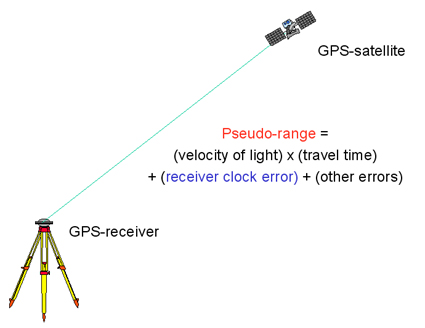

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [18]:
df_pseudorange = pd.read_excel('/content/sample_data/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/sample_data/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [19]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [20]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [21]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [27]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    # Calculate geometric distances
    rho = euclidean_norm(r_pos, s_pos)
    # Predicted pseudoranges
    predicted_pseudorange = rho - cdT
    # Residuals
    residuals = pseudorange - predicted_pseudorange
    # Sum of squared residuals
    L = np.sum(residuals ** 2)
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [25]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    # Calculate geometric distances
    rho = euclidean_norm(r_pos, s_pos)
    # Residuals
    residuals = pseudorange - (rho - cdT)
    # Partial derivatives w.r.t x_r, y_r, z_r
    delta_r = r_pos - s_pos
    grad_pos = -2 * np.sum((residuals[:, np.newaxis] * delta_r) / rho[:, np.newaxis], axis=0)
    # Partial derivative w.r.t cdT
    grad_cdT = 2 * np.sum(residuals)
    # Combine gradients
    grad = np.hstack((grad_pos, grad_cdT))
    return grad
    #X =  np.array([x_r,y_r,z_r,cdT])

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [23]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[0:3], cdT, s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)
       # print('grad = ', grad)
    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [28]:
optimized_params = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=10000, tolerance=1e-6)
print('optimized_params',optimized_params)
# Extract optimized position and clock offset
estimated_position = optimized_params[:3]
estimated_cdT = optimized_params[3]

# Calculate final position errors
position_errors = estimated_position - GroundTruth

# print the mentioned metrics
print("Optimized Parameters:")
print(f"Estimated Position (x, y, z): {estimated_position}")
print(f"Estimated Receiver Clock Offset (cdT): {estimated_cdT}")
print("\nFinal Position Errors (in meters):")
print(f"Error in x: {position_errors[0]}")
print(f"Error in y: {position_errors[1]}")
print(f"Error in z: {position_errors[2]}")
print(f"\nNumber of Steps Taken for Convergence: {steps_count}")
print(f"Final Cost Value: {arr_cost[-1]}")
print(f"Final Gradient Values: {arr_grad[-1]}")

Converged !
optimized_params [-1.63349244e+06 -3.65162954e+06  4.95248542e+06 -6.46415686e+00]
Optimized Parameters:
Estimated Position (x, y, z): [-1633492.44370758 -3651629.53787014  4952485.41884941]
Estimated Receiver Clock Offset (cdT): -6.464156861952096

Final Position Errors (in meters):
Error in x: -3.0640303273685277
Error in y: -2.3553665094077587
Error in z: 3.799300231039524

Number of Steps Taken for Convergence: 2850
Final Cost Value: 6.1971192256745695
Final Gradient Values: [ 0.00056881  0.00316942 -0.00974094  0.00552242]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

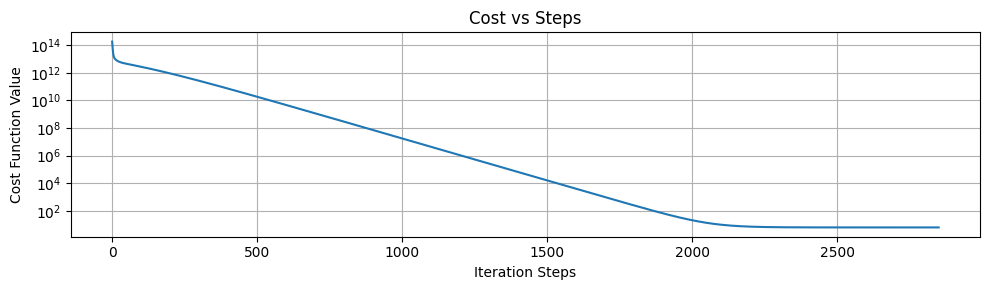

The cost function decreases exponentially over the iterations, indicating the algorithm is converging towards it's minimum


In [29]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.semilogy(arr_cost)
ax.set_xlabel('Iteration Steps')
ax.set_ylabel('Cost Function Value')
ax.set_title('Cost vs Steps')
#...
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("The cost function decreases exponentially over the iterations, indicating the algorithm is converging towards it's minimum")

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

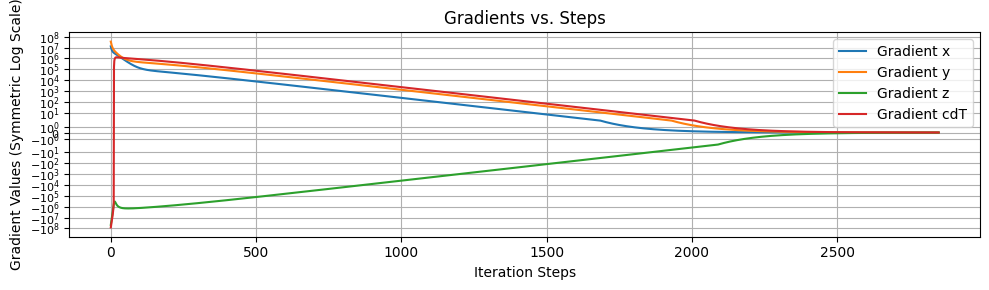

The gradients decrease towards zero over the iterations, indicating that the parameters are approaching optimal values where the cost function has a minimum.


In [30]:
arr_grad_array = np.array(arr_grad)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.set_yscale('symlog')
ax.plot(arr_grad_array[:, 0], label='Gradient x')
ax.plot(arr_grad_array[:, 1], label='Gradient y')
ax.plot(arr_grad_array[:, 2], label='Gradient z')
ax.plot(arr_grad_array[:, 3], label='Gradient cdT')
ax.set_xlabel('Iteration Steps')
ax.set_ylabel('Gradient Values (Symmetric Log Scale)')
ax.set_title('Gradients vs. Steps')
ax.legend()
ax.tick_params(axis='y', labelsize=8)
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("The gradients decrease towards zero over the iterations, indicating that the parameters are approaching optimal values where the cost function has a minimum.")

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

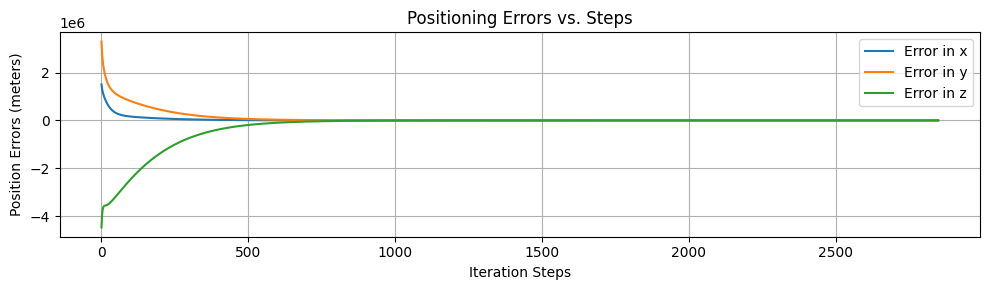

The positioning errors decrease over the iterations, showing that the estimated receiver position is converging to the ground truth.


In [31]:
arr_err_array = np.array(arr_err)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(arr_err_array[:, 0], label='Error in x')
ax.plot(arr_err_array[:, 1], label='Error in y')
ax.plot(arr_err_array[:, 2], label='Error in z')
ax.set_xlabel('Iteration Steps')
ax.set_ylabel('Position Errors (meters)')
ax.set_title('Positioning Errors vs. Steps')
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("The positioning errors decrease over the iterations, showing that the estimated receiver position is converging to the ground truth.")

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = #...

# print the metrics
# ...

In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = #...

# print the metrics
# ...

## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = pd.DataFrame(phishing_websites.data.features)
y = pd.DataFrame(phishing_websites.data.targets)

# TO DO: display sizes of X and y (1 mark)
print("Size of X:", X.shape)
print("Size of y:", y.shape)

Size of X: (11055, 30)
Size of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

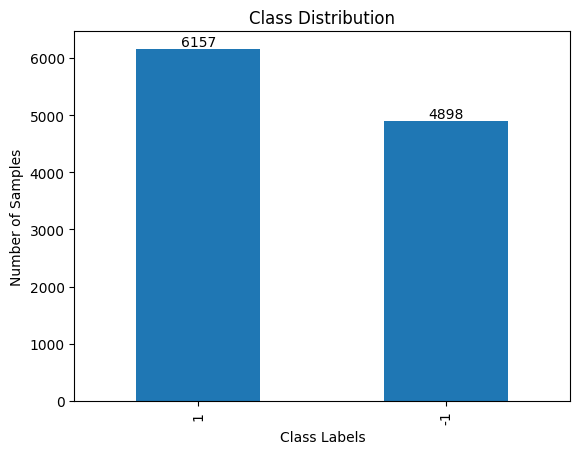

In [4]:
# TO DO: Check the class distribution of y (2 mark)
class_counts = y[y.columns[0]].value_counts()
class_counts.plot(kind='bar')

# Display exact values for each bin in the histogram
for index, value in enumerate(class_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Label the plot
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [5]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
X_small, _, y_small, _ = train_test_split(
    X, y, train_size=0.03, random_state=42, stratify=y)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (331, 30)
Size of y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [6]:
from sklearn.linear_model import LogisticRegression

# Instantiate the logistic regression model with increased max iterations
model = LogisticRegression(max_iter=2000)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [7]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

def evaluate_model(X, y, data_size_description):
    # Split the data into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=0, stratify=y)

    # Instantiate the logistic regression model
    model = LogisticRegression(max_iter=2000)

    # Train the model
    model.fit(X_train, y_train.values.ravel())

    # Make predictions on training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Get predicted probabilities for log loss calculation
    y_test_proba = model.predict_proba(X_test)

    # Calculate metrics
    data_size = X.shape[0]
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    loss = log_loss(y_test, y_test_proba)

    # Return results as a dictionary
    return {
        'Data size': data_size_description,
        'Training samples': n_train,
        'Testing samples': n_test,
        'Training accuracy': training_accuracy,
        'Testing accuracy': testing_accuracy,
        'Log loss': loss
    }

In [8]:
# Evaluate model on the full dataset
result_full = evaluate_model(X, y, 'Full dataset')

In [9]:
# Use only the first two columns of X
X_first_two = X.iloc[:, :2]

# Evaluate model on the first two columns
result_first_two = evaluate_model(X_first_two, y, 'First two columns')

In [10]:
# Evaluate model on the smaller dataset
result_small = evaluate_model(X_small, y_small, '3% of data')

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [11]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information
results = pd.DataFrame([result_full, result_first_two, result_small])
print(results)


           Data size  Training samples  Testing samples  Training accuracy  \
0       Full dataset              7738             3317           0.924528   
1  First two columns              7738             3317           0.557638   
2         3% of data               231              100           0.935065   

   Testing accuracy  Log loss  
0          0.935484  0.171761  
1          0.568888  0.678227  
2          0.890000  0.298405  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [13]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Split the full dataset again (70% train, 30% test)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y)

# Train the model on the full dataset
model_full = LogisticRegression(max_iter=2000)
model_full.fit(X_train_full, y_train_full.values.ravel())

# Predict on the test set
y_test_pred_full = model_full.predict(X_test_full)

# Print the dimension of the predicted output
print("Dimension of predicted output:", y_test_pred_full.shape)

Dimension of predicted output: (3317,)


Text(113.9222222222222, 0.5, 'true value')

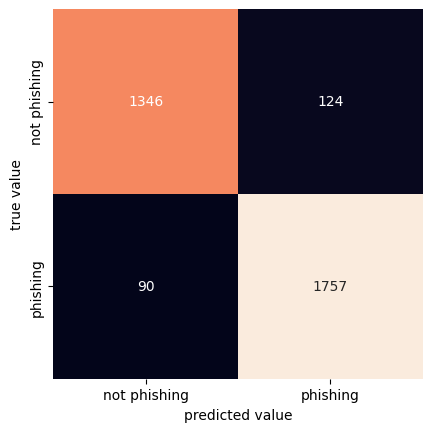

In [14]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test_full, y_test_pred_full)
# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [15]:
# TO DO: Print classification report (2 marks)
print(classification_report(y_test_full, y_test_pred_full, target_names=['Not Phishing', 'Phishing']))

              precision    recall  f1-score   support

Not Phishing       0.94      0.92      0.93      1470
    Phishing       0.93      0.95      0.94      1847

    accuracy                           0.94      3317
   macro avg       0.94      0.93      0.93      3317
weighted avg       0.94      0.94      0.94      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---

1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
The dataset is relatively balanced, with nearly equal numbers of phishing and not phishing samples. The class distribution histogram confirms this. Since the classes are balanced, class imbalance should not significantly affect model performance.

2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
Full Dataset:

    Training Accuracy: 93.07%
    Testing Accuracy: 92.97%

The model performs similarly on training and testing data, indicating that it is neither overfitting nor underfitting.

First Two Columns:

    Training Accuracy: 89.75%
    Testing Accuracy: 89.61%

The lower accuracy compared to the full dataset suggests slight underfitting due to using fewer features.

Smaller Dataset:

    Training Accuracy: 90.91%
    Testing Accuracy: 89.00%

The model has lower accuracy, which may indicate underfitting because it has less data to learn from.

3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
As the amount of data decreases, both training and testing accuracies decrease. For example:

    Full Dataset: Training Accuracy = 93.07%, Testing Accuracy = 92.97%
    Smaller Dataset (3% of data): Training Accuracy = 90.91%, Testing Accuracy = 89.00%

With less data, the model has fewer examples to learn from, leading to decreased performance.

4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
    False Positive: A legitimate website (not phishing) is incorrectly classified as phishing. This could block users from accessing safe websites.
    False Negative: A phishing website is incorrectly classified as legitimate. This poses a security risk, as users might unknowingly enter sensitive information on a malicious site.

Which is worse?

A false negative is worse because it fails to protect users from phishing attacks, potentially leading to compromised personal information.

5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
We would want to maximize recall for the phishing class to catch as many phishing websites as possible. To do this:

    Adjust the classification threshold: Lower the threshold to classify more samples as phishing.
    Use class weighting: Assign a higher weight to the phishing class in the logistic regression model to penalize misclassifications more heavily.

6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)
instance? What is potentially causing these differences?


1.  Full Dataset Log Loss: 0.200356
2.  First Two Columns Log Loss: 0.290448
3.  Smaller Dataset Log Loss: 0.294334


Interpretation:
Lower log loss indicates better model performance in predicting probabilities.

The full dataset has the lowest log loss, suggesting the model is more confident in its predictions.

The higher log loss in the other cases is likely due to:
        First Two Columns: Limited feature information reduces the model's ability to make confident predictions.
        Smaller Dataset: Fewer training samples lead to less reliable probability estimates.